# Introduction

## Context

Kaggle is hosting a **Climate Change Belief Analysis** competition which aims to predict an individual's belief in climate change based on historical tweet data.

The results from the prediction will help companies better understand their customer's perception on climate change. Such an analysis or prediction will help companies determine how their products will be recieved; thus guiding their marketing strategy and their production processes.


## Problem Statement

Companies are looking to create products and services that are environmentally friendly. They would thus like to understand their consumers' view on climate change. To address this, we are going to create Machine Learning models that are able to classify whether or not a person believes in climate change, based on their novel tweet data. Correct classification of a tweet will help companies understand consumer sentiment, which will further guide their business strategies.


## Data Sets

The data sets provided by host of the competition provide us with a message (tweet) and the tweet id. The tweets are related to the topic of climate change. 

The data sets used in the notebook:
    - train.csv : data used to train models; loaded as train_data in our notebook.
    - test.csv : data used to test the models; loaded as test_data in our notebook.
    
The train.csv data sis composed of 15819 tweets whilst the test.csv is composed of 10546 tweets. Below we go through the data sets to try and understand its composition further.

# Data Exploration
## Import packages and load data files
###### task: import and load data
We start off by importing packages and loading data

In [3]:
# !pip install spacy

In [5]:
# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

import re
import string
import spacy
import nltk
from spacy import displacy
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_md')
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load Data
train_data = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/train.csv',index_col='tweetid')
test_data = pd.read_csv('https://raw.githubusercontent.com/team-rm4-JHB-classificationpredict/team_rm4_JHB_classification/master/predict_deliverables/data/test.csv',index_col='tweetid')

## Variable Descriptions

- **sentiment**: Sentiment of tweet (pro, anti, neutral,news).

- **message**: Tweet body (raw tweet).

- **tweetid**: Twitter unique id (unique integer).

## Target Variable (sentiment)
-  **1 : Pro** --> the tweet supports the belief of a man-made climate change.
-  **2 : News** --> the tweet links to factual news about climate change.
-  **0 : Neutral** --> the tweet neither supports nor refutes the belief of a man-made climate change.
- **-1 : Anti** --> the tweet does not believe in a man made climate change

###### task: display the shape of the data sets
Here we display the shape of both the test and the train data to get an understanding of the features in the data sets. Below, we can see that the train data has 15819 rows of tweets and 2 columns. The columns would be the sentiment as well as the message. However, the test data only has one column (message). From the models that will be trained, we should be able to create a sentiment column for the test data too. The entries for this column will be predicted from the train data.

In [14]:
print(f'Train data shape:\t{train_data.shape}\nTest data shape:\t{test_data.shape}')

Train data shape:	(15819, 2)
Test data shape:	(10546, 1)


###### task: Display the number of entries per category in the sentiment column
This is done to try and understand the distribution of entries in the sentiment column. Given that this is our target variable (sentiment), it is important that the data is somewhat balanced to avoid bias towards the categories with higher entries. That is, to reduce the likelihood that predictions will classify tweets as the category with the most entries.

Below we have created a dataframe that shows the number of entries per category and the percentage of those entries as a faction of the total entries.

In [61]:
# count the entries per column and save them in a dataframe
categories = train_data['sentiment'].value_counts().to_frame()
categories.index.rename('categories',inplace=True)
categories.rename({'sentiment':'no_of_entries'},axis=1,inplace=True)
categories['percentage'] = [round(count/len(train_data),2) for count in categories['no_of_entries']]
categories

,no_of_entries,percentage
categories,,
1,8530,0.54
2,3640,0.23
0,2353,0.15
-1,1296,0.08


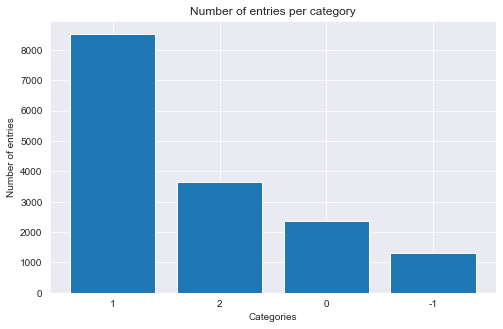

In [66]:
# plot a bar chart which shows the distribution of the entries
plt.figure(figsize=(8,5))

plt.bar(x=['1','2','0','-1'],height=categories['no_of_entries'])
plt.title('Number of entries per category')
plt.xlabel('Categories')
plt.ylabel('Number of entries')
plt.show()
#del categories

As it can be seen above, the sentiment belonging to category 1 (Pro climate change belief) is significantly higher than the other categories. In comparison to category -1 (Anti climate change belief), if a model were to be trained with this two categories only, the model not be a good classifier as it would penalise the smaller category by predicting category 1 more often. In the data processing section of this notebook, we will look into methods like resampling to try and balance the distribution of the entries.

###### task: display the head of both the test and train data

In [12]:
train_data.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [13]:
test_data.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


## Missing Values
In this section we will be looking out for any missing values (i.e: np.nan values) and or all the tweets that are just empty strings.
- In the code cell below, we can see that no column of the train data has np.nan values.

In [17]:
pd.DataFrame(train_data.isnull().sum(),columns=['mising_values'])

,mising_values
sentiment,0
message,0


- Here we seek to remove any empty strings from the 'message' column.

In [24]:
print(f"Length before check:\t{len(train_data)}")

blanks = [] # store the indices of the space's tweets

for index, sent, mess in train_data.itertuples():
    if type(mess)==str:
        if mess.isspace():
            blanks.append(index)

# drop rows from dataframe if there are any empty tweets/strings            
train_data.drop(blanks,axis=0,inplace=True)

print(f"Length after check:\t{len(train_data)}")

Length before check:	15819
Length after check:	15819


As it can be seen from the above, there aren't any np.nan values nor are there any empty strings from the train_data dataframe.
What we are going to explore next is if there are any tweets that might not be sufficient in length to form an english sentence (say a tweet with one, two or maybe even three words).

In [33]:
print(f'''Number of tweets that might not form an english sentence:
      {len([tweet for tweet in train_data.message if len(tweet)<=5])}''')

Number of tweets that might not form an english sentence:
      0


###### Conclude
In this section we managed to import packages, load data, descibe the features and the target variable. We have also managed to look at the head (top five entries) of the dataframes. We have looked at the possibility of empty strings, np.nan values and even tweets (messages) that might not be sufficient enough to form an english sentence that makes sense. After this exploration, we have't performed any transformation on the data.

Before we go into any Data transformation or hyperparameter tunning, we fit models with the raw data. Once we have looked at the models before any preprocessing, we will then explore different methods of how we can go about preprocessing our data to better improve the performance of our models.

# Base Models
Train models with minimal data preprocessing.
Given the nature of the feature (message column), we will apply the term frequency–inverse document frequency Vectorizer (TfidfVectorizer) to the data so that it can be converted to a matrix of TF-IDF features, which are numerical and a machine learning algorithm can understand.

**Models to be trained**:
- Logistic Regression
- Support Vector Classification (SVC)
- Linear SVC
- Multinomial Naive Bayes classifier
- Random Forest Classifier
- Neural Network Sequence model

All of the above models will be trained through pipelines.

###### task: import packages
Import packages that will make the modelling possible.

In [92]:
from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Dropout

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

## Split the data
Split the train_data into training and testing data. This is to make sure that there isn't any leakage of information when we actually fit the test_data that we imported. To avoid overfitting, we are using the train_data to train and test our models.

In [160]:
# split into dependent and independent arrays
X = train_data['message'].values
y = train_data['sentiment'].values

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Create pipelines
###### task: create pipelines with a vectorizer.
The pipelines created here are to be used to train the specified models above. The pipelines will apply the TfidfVectorizer to the training data before it fits the model.

In [161]:
# SVC pipeline
svc_clf = Pipeline([('vectorizer',TfidfVectorizer()),('SVC',SVC())])

# LinearSVC pipeline
linear_svc_clf = Pipeline([('vectorizer',TfidfVectorizer()),
                            ('Linear_SVC',LinearSVC())])

# Random Forest Classiffier pipeline
random_f_clf = Pipeline([('vectorizer',TfidfVectorizer()),
                         ('Random_Forest',RandomForestClassifier())])

# MultinomialNB pipeline
multinom_clf = Pipeline([('vectorizer',TfidfVectorizer()),('Multinomial',
                                                    MultinomialNB())])

# logistic Regression pipeline
logistic_clf = Pipeline([('vectorizer',TfidfVectorizer()),('Logistic_regr',
                                LogisticRegression(multi_class='ovr'))])

## Train base models
In this section we define functions that tests the five models mentioned above (logistic regression, svc, linear svc, multinomial naive's Bayes, the random classifier and a Neural Network with muliple layers). Once the models are trained, we return a performance dataframe with the weighted average F1 scores as well as the accuracy scores of the models trained. We are interested in the performance of the weighted average f1 score as it adjusts for the precision and the recall scores. The functions will also return the trained models so that they can be used to evaluate other metrices.

In [162]:
def models_to_train(X_train,X_test,y_train,y_test):
    '''
    Train models and return a dataframe of their perfomance. The function
    also returns the trained models for later use.
    
    Parameters
    ----------
    X_train : numpy array
        A numpy array of the shape (len(X_train), n), where n is any integer
        greater than 0.
    X_test : numpy array
        A numpy array of the shape (len(X_test), n), where n is any integer
        greater than 0.
    y_train : numpy array
        A numpy array of the shape(len(y_train),), with the values being the
        categories or target values.
    
    y_train : numpy array
        A numpy array of the shape(len(y_train),), with the values being the
        categories or target values
        
    Returns
    -------
    dataframe : pandas.core.frame.DataFrame
        A pandas dataframe with two columns; weighted average f1 score and the
        accuracy score of each model.
    dictionary : dict
        A dictionary of all the trained models
    '''
    
    # create a dictionary of all the untrained models
    trained_models = {'Logistic_regression':logistic_clf,
                      'SVC':svc_clf,'LinearSVC':linear_svc_clf,
                      'MultinomialNB':multinom_clf,'Random_Forest':random_f_clf}
    
    performance = {} # dictionary to store performance
    
    for name,model in trained_models.items():
        
        # fit the model
        model.fit(X_train, y_train)
        
        # prediction of y
        y_predicted = model.predict(X_test)

        # calculate the weighted average score and the accuracy score.
        weighted_avg = classification_report(y_test,y_predicted)[-15:-11]
        acc_score = accuracy_score(y_test,y_predicted)

        performance[name] = {'weighted_average':float(weighted_avg),
                            'accuracy_score':round(acc_score,4)}

        #print(f"{name}:\n{classification_report(y_test,y_predicted)}\n")
    
    # convert the performance dictionary to a dataframe
    performance = pd.DataFrame(performance).T.sort_values(by='weighted_average',ascending=False)
    
    return performance, trained_models

The function above trains the logistic regression, svc, linear svc, multinomialNB and the random forest classiffier. The code cell below applies the above defined function:

In [163]:
# run the function to train the models
performance, trained_models = models_to_train(X_train,X_test,y_train,y_test)

###### task: define a neural network function
The neural network will use the Sequential method with a maximum number of words of 50000, maximum sequence of 250 and an embedding of 100. The function will first tokenize the data, split it accordingly and then train a Sequencial model. We will be doing a recurrent network. This is done to make sure that there is little to no linearity in the features that are used to train the model. Once the model has been trained, we return a dataframe of the weighted average f1 score as well as the accuracy score. Like the previous function, we will be returning the trained model too so that it can be reused later if need be

In [164]:
def sequence_model(df,performance):
    '''
    Return a dataframe of performance and a trained model.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        A pandas dataframe with the columns 'sequence' and 'message'.
    
    performance : pandas.core.frame.DataFrame
        A pandas dataframe with performance metrices for previously
        trained models.
        
    Returns
    -------
    dataframe : pandas.core.frame.DataFrame
        A performance dataframe with the weighted f1 scores and the 
        accuracy score of each model trained.
    keras model : keras.engine.sequential.Sequential
        A sequential model that can be used for predictions.
    '''
    
    max_no_words, max_sequence, embedding = 50000, 250, 100

    tokenizer = Tokenizer(num_words=max_no_words)
    tokenizer.fit_on_texts(df['message'].values)
    word_index  = tokenizer.word_index

    X = tokenizer.texts_to_sequences(df['message'].values)
    X = pad_sequences(X,maxlen=max_sequence)

    y = to_categorical(df['sentiment'].values,num_classes=4)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=4)
    
    # instantiate a sequential model.
    model = Sequential()
    
    # add layers to the model
    model.add(Embedding(max_no_words,embedding,input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                  metrics=['accuracy'])

    # fit the model with 6 epochs of batxh size 50.
    model.fit(X_train,y_train,epochs=6,batch_size=50,
            callbacks=[EarlyStopping(monitor='val_loss',
            patience=3, min_delta=0.0001)],verbose=1,validation_split=0.1)
    
    # make predictions
    y_predicted = model.predict(X_test)
    y_predicted = y_predicted.argmax(axis=1)
    y_test=y_test.argmax(axis=1)

    # calculate performance matrices
    weighted_avg = classification_report(y_test,y_predicted)[-15:-11]
    acc_score = accuracy_score(y_test,y_predicted)
    
    model_performance = pd.Series(data={'weighted_average':weighted_avg,
                      'accuracy_score':acc_score},name='Sequencial')
    
    performance = performance.append(model_performance,
                                     ignore_index=False).astype('float')
    
    performance = performance.sort_values(by='weighted_average',ascending=False)
    
    return performance, model

Apply the function above and add the returned model to the trained models dictionary returned by the models_to_train() function.

In [165]:
performance, model = sequence_model(train_data,performance)
trained_models['Deep_learning'] = model

Train on 9965 samples, validate on 1108 samples
Epoch 1/6
9965/9965 [==============================] - 171s 17ms/step - loss: 0.9609 - accuracy: 0.6186 - val_loss: 0.7571 - val_accuracy: 0.7094
Epoch 2/6
9965/9965 [==============================] - 168s 17ms/step - loss: 0.6056 - accuracy: 0.7595 - val_loss: 0.7196 - val_accuracy: 0.7193
Epoch 3/6
9965/9965 [==============================] - 166s 17ms/step - loss: 0.3437 - accuracy: 0.8696 - val_loss: 0.7718 - val_accuracy: 0.7211
Epoch 4/6
9965/9965 [==============================] - 171s 17ms/step - loss: 0.1760 - accuracy: 0.9398 - val_loss: 0.8972 - val_accuracy: 0.7229
Epoch 5/6
9965/9965 [==============================] - 169s 17ms/step - loss: 0.0904 - accuracy: 0.9722 - val_loss: 0.9445 - val_accuracy: 0.7094


## Performance Evaluation
###### task: Visualise the performance of the models


In [169]:
performance

,weighted_average,accuracy_score
LinearSVC,0.74,0.750100
Deep_learning,0.72,0.729035
SVC,0.70,0.727300
Logistic_regression,0.69,0.716600
Random_Forest,0.66,0.696200
MultinomialNB,0.52,0.619300


The accuracy score is consistently above the the weighted average f1 score for all the models that have been trained. This can be attributed to the imbalance in the entries of the sentiment column in the original data. This will however be explored in the nect section as we preprocess our data to try and improve the performance of our model.

From the models that we have trained by far, The LinearSVC is currently outperforming all the other models that have been trained on the same data. We will however opt to work on improving the performance of all our models in an attempt to get a model that will perform best.

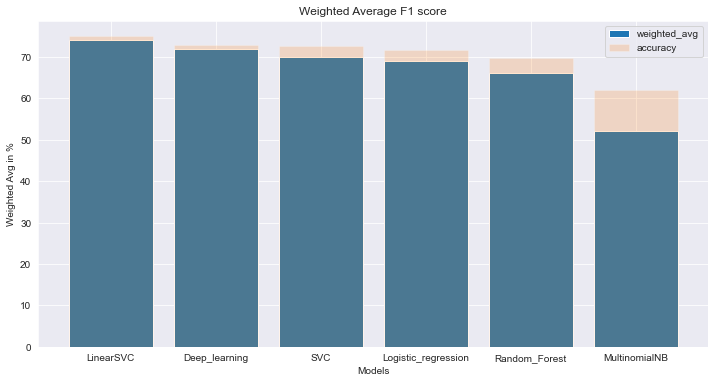

In [197]:
x = list(performance.index)
height = [i*100 for i in performance.weighted_average]
plt.figure(figsize=(12,6))
plt.bar(x,height,label='weighted_avg')
plt.bar(x,height=[i*100 for i in performance.accuracy_score],alpha=0.2,label='accuracy')
plt.title('Weighted Average F1 score')
plt.xlabel('Models')
plt.ylabel('Weighted Avg in %')
plt.legend()
plt.show()

# Data Transformation
## Performance Evaluation

# Hyperparameter Tunning
## Performance Evaluation

# Model Training

# Performance Assessment

# Summary & Conclusion